<a href="https://colab.research.google.com/github/HungDuongXuan/BTL_XLA/blob/main/VietnameseHandwritingOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/XLA/Dataset/images"
DATA_LABELS = "/content/drive/MyDrive/XLA/Dataset/labels.json"
IMAGE_SIZE = (118, 2167)
TEST_SIZE = 0.2
TIME_STEPS = 240
BATCH_SIZE = 32
EPOCHS = 100

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  True
Mounted at /content/drive


In [ ]:
with open(DATA_LABELS , 'r', encoding='utf8') as f:
    train_labels = json.load(f)

char_list = set()
for label in train_labels.values():
    char_list.update(set(label))
char_list=sorted(char_list)
"".join(char_list)

"".join(char_list)

" #'()+,-./0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghiklmnopqrstuvwxyzÁÂÊÍÔÝàáâãèéêìíòóôõùúýăĐđĩũơƯưạẢảẤấầẩẫậắằẵặẹẻẽếềểễệỉịọỏốồỔổỗộớờỞởỡợụủỨứừửữựỳỵỷỹ"

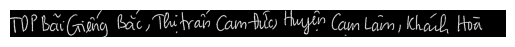

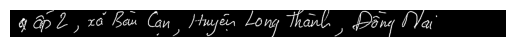

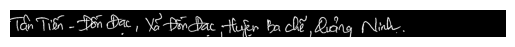

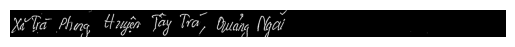

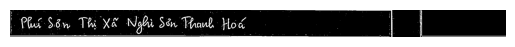

In [ ]:
all_image_paths = list(train_labels.keys())
train_image_paths, val_image_paths = train_test_split(all_image_paths, test_size=TEST_SIZE, random_state=42)

def encode_to_labels(txt):
    dig_lst = []
    for char in txt:
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("Not found in char_list :", char)
    return dig_lst

def process_image(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    height, width = img.shape
    img = cv2.resize(img, (int(IMAGE_SIZE[0] / height * width), IMAGE_SIZE[0]))
    height, width = img.shape
    img = np.pad(img, ((0, 0), (0, IMAGE_SIZE[1] - width)), 'median')
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    img = np.expand_dims(img, axis=2)
    img = img / 255.0
    return img

def process_data(image_paths):
    imgs = []
    txts = []
    input_length = []
    label_length = []
    orig_txt = []

    for img_path in image_paths:
        full_path = os.path.join(DATA_PATH, img_path)
        img = process_image(full_path)
        label = train_labels[img_path]
        imgs.append(img)
        orig_txt.append(label)
        txts.append(encode_to_labels(label))
        input_length.append(TIME_STEPS)
        label_length.append(len(label))

    imgs = np.array(imgs)
    padded_txt = pad_sequences(txts, maxlen=TIME_STEPS, padding='post', value = 0)
    input_length = np.array(input_length)
    label_length = np.array(label_length)

    return imgs, padded_txt, input_length, label_length, orig_txt

train_img, train_padded_txt, train_input_length, train_label_length, orig_txt = process_data(train_image_paths)
valid_img, valid_padded_txt, valid_input_length, valid_label_length, valid_orig_txt = process_data(val_image_paths)

for ig in train_img[:5]:
    plt.imshow(ig.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
def build_model():
    inputs = Input(shape=IMAGE_SIZE+(1,))
    # Block 1
    x = Conv2D(64, (3,3), padding='same')(inputs)
    x = MaxPool2D(pool_size=3, strides=3)(x)
    x = Activation('relu')(x)
    # Block 2
    x = Conv2D(128, (3,3), padding='same')(x)
    x = MaxPool2D(pool_size=3, strides=3)(x)
    x = Activation('relu')(x)
    # Block 3
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x_3 = x
    # Block4
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x,x_3])
    x = Activation('relu')(x)
    # Block5
    x = Conv2D(512, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x_5 = x
    # Block6
    x = Conv2D(512, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x,x_5])
    x = Activation('relu')(x)
    # Block7
    x = Conv2D(1024, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(3, 1))(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 1))(x)
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)

    blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
    blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
    return inputs, outputs

inputs, outputs = build_model()
act_model = Model(inputs, outputs)
act_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 118, 2167, 1)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 118, 2167, 64)  │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 39, 722, 64)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 39, 722, 64)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 39, 722, 128)   │         73,856 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 13, 240, 128)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 13, 240, 128)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 13, 240, 256)   │        295,168 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 13, 240, 256)   │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 13, 240, 256)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 13, 240, 256)   │        590,080 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 13, 240, 256)   │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 13, 240, 256)   │              0 │ batch_normalization_1… │
│                           │                        │                │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 13, 240, 256)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 13, 240, 512)   │      1,180,160 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 13, 240, 512)   │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,974,422 (83.83 MB)

 Trainable params: 21,969,302 (83.81 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [ ]:
labels = Input(name='the_labels', shape=[TIME_STEPS], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath='/content/drive/MyDrive/XLA/chkpt/{epoch:02d}_{val_loss:.4f}.weights.h5', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', min_delta=1e-8, factor=0.2, patience=10, verbose=1)
]

history = model.fit(x=[train_img, train_padded_txt, train_input_length, train_label_length],
          y=np.zeros(len(train_img)),
          batch_size=BATCH_SIZE,
          epochs = EPOCHS,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.0000e+00 - loss: 263.3304 - val_accuracy: 0.0000e+00 - val_loss: 164.2337 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.0000e+00 - loss: 162.2479 - val_accuracy: 0.0000e+00 - val_loss: 185.3829 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.0000e+00 - loss: 158.0059 - val_accuracy: 0.0000e+00 - val_loss: 195.8834 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.0000e+00 - loss: 155.7574 - val_accuracy: 0.0000e+00 - val_loss: 208.1362 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.0000e+00 - loss: 156.1775 - val_accuracy: 0.0000e+00 - val_loss: 233.8914 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.0000e+00 - loss: 149.5057 - val_accuracy: 0.0000e+00 - val_loss: 289.0750 - learning_rate: 0.0010
Epoch 7/100
63/6

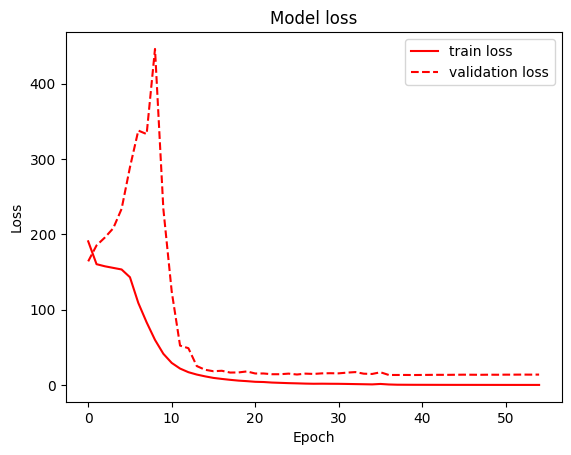

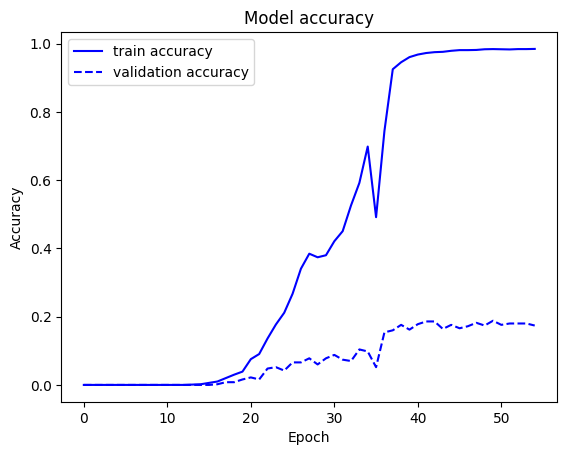

In [ ]:
# Hàm vẽ biểu đồ độ chính xác của quá trình huấn luyện và xác thực
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='train accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='validation accuracy', color='blue', linestyle='dashed')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

# Hàm vẽ biểu đồ mất mát của quá trình huấn luyện và xác thực
def plot_loss(history):
    plt.plot(history.history['loss'], label="train loss", color='red')
    plt.plot(history.history['val_loss'], label="validation loss", color='red', linestyle='dashed')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_loss(history)  # Vẽ biểu đồ mất mát
plot_accuracy(history)  # Vẽ biểu đồ độ chính xác


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


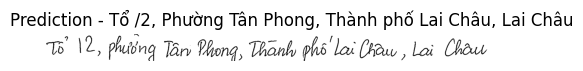

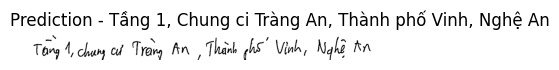

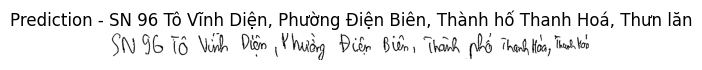

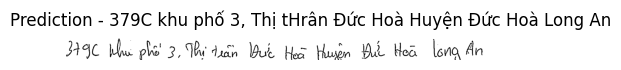

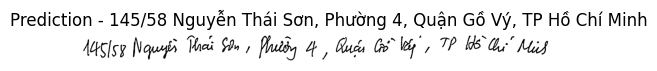

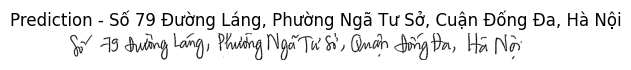

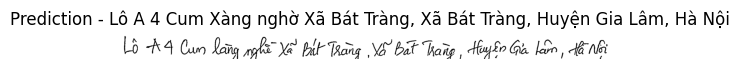

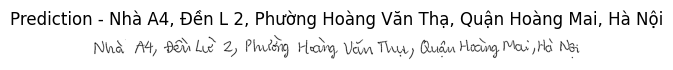

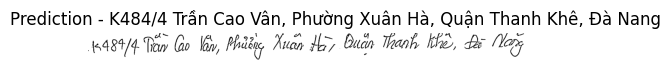

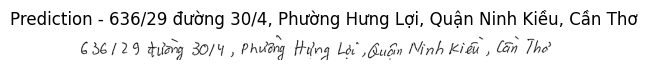

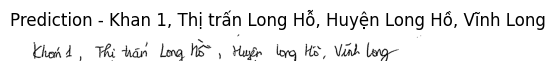

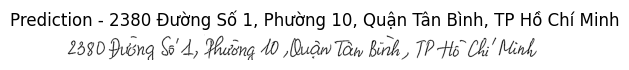

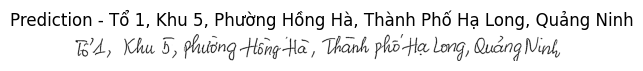

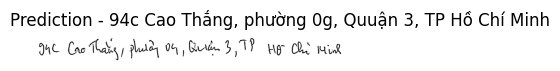

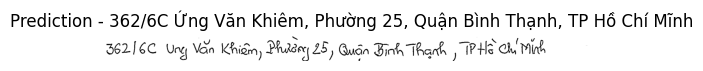

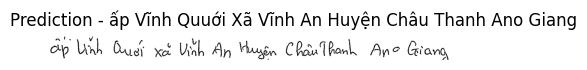

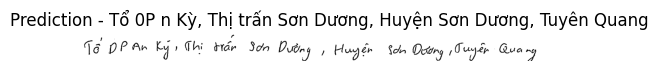

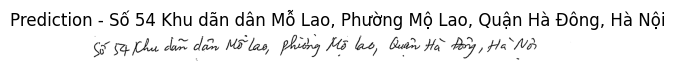

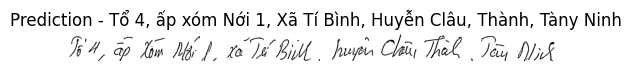

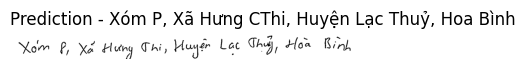

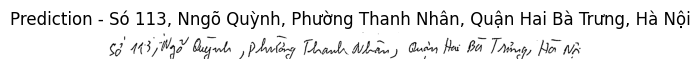

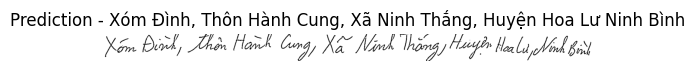

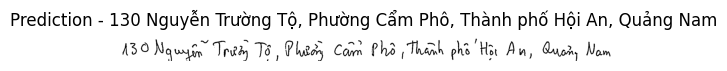

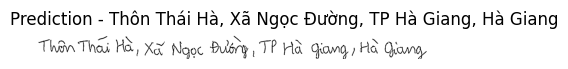

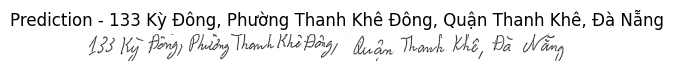

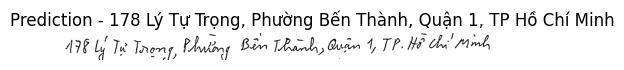

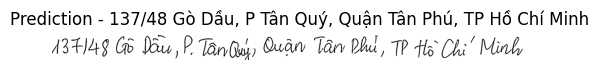

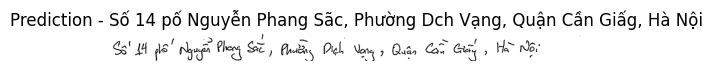

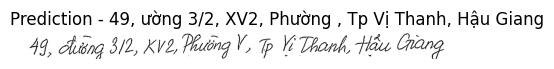

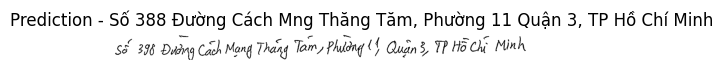

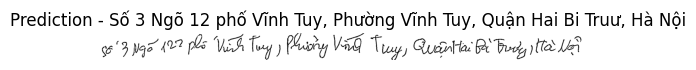

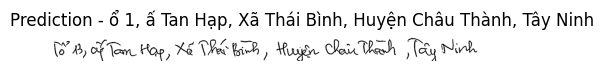

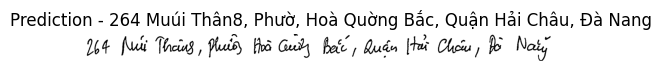

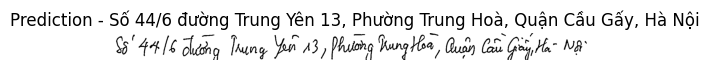

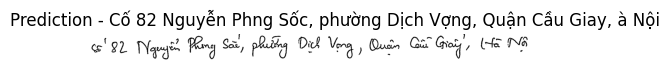

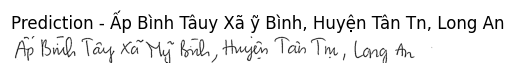

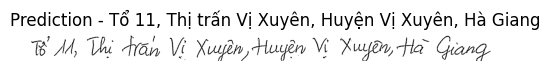

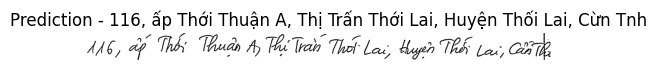

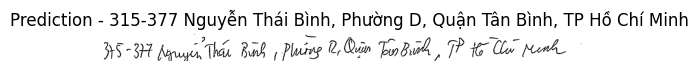

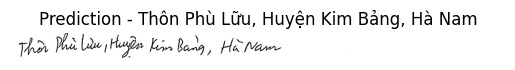

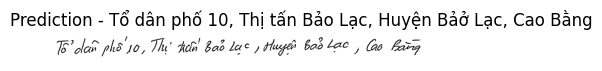

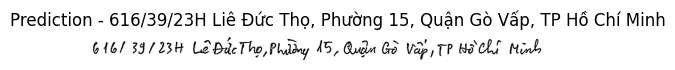

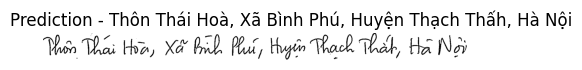

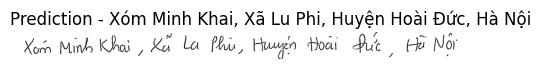

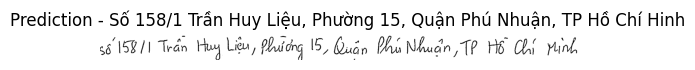

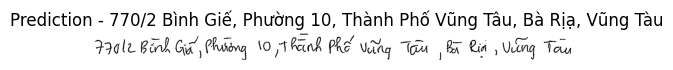

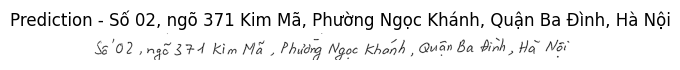

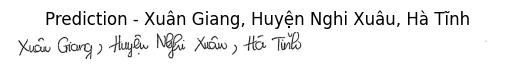

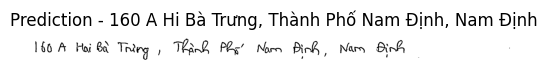

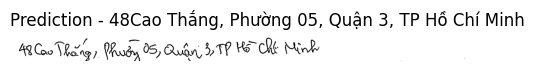

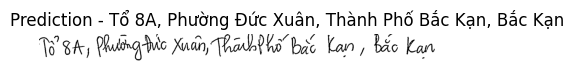

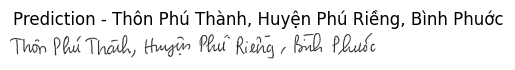

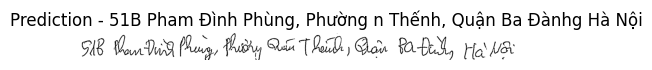

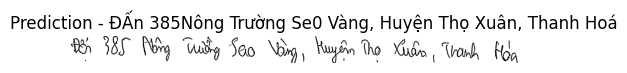

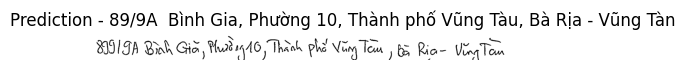

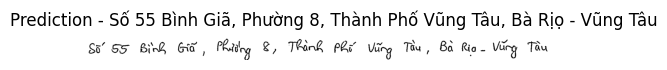

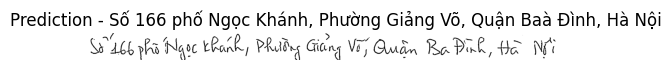

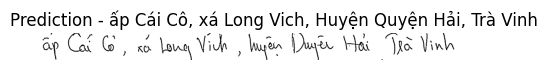

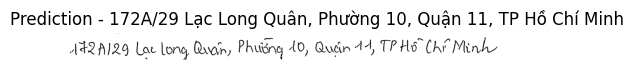

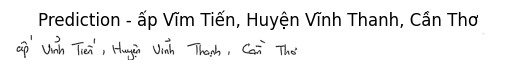

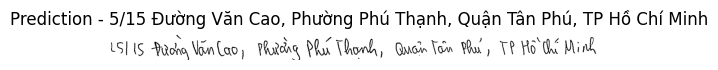

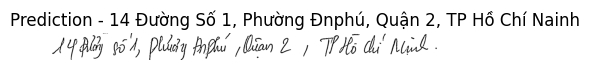

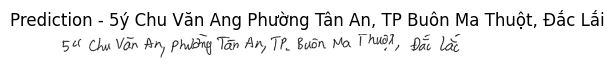

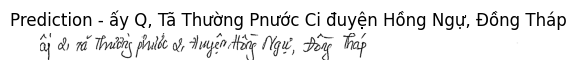

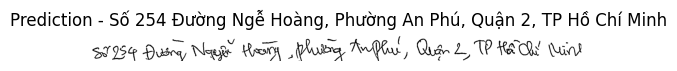

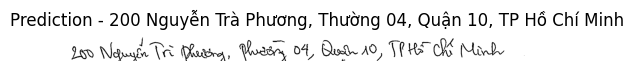

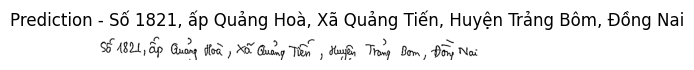

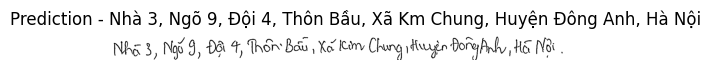

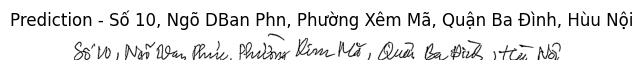

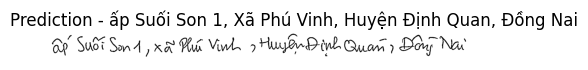

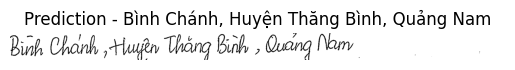

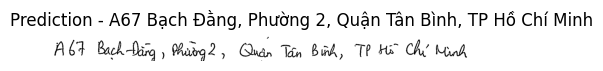

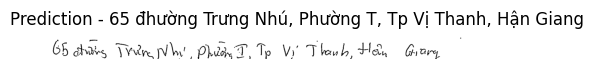

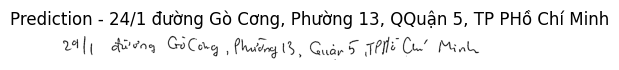

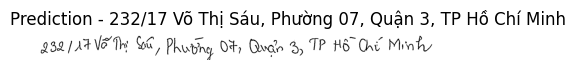

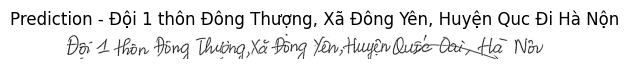

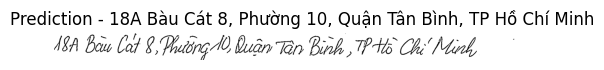

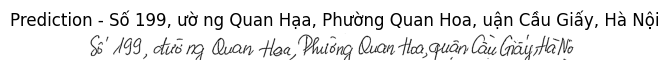

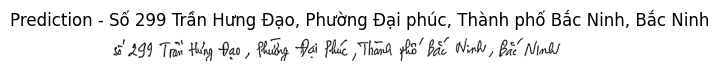

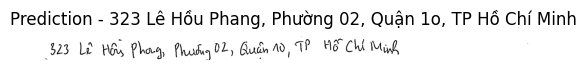

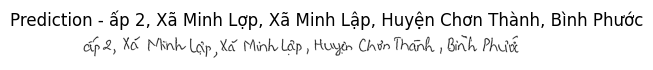

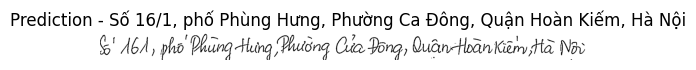

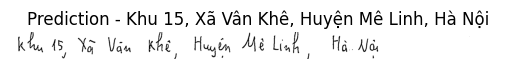

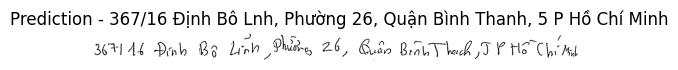

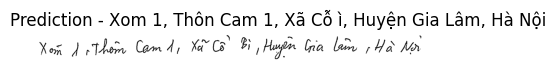

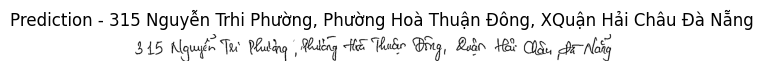

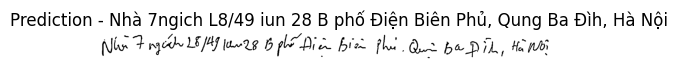

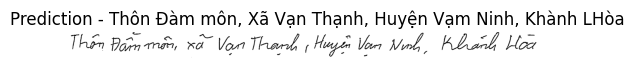

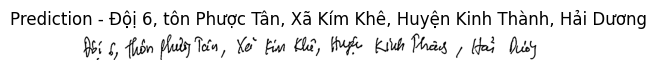

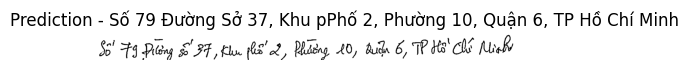

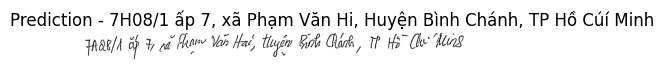

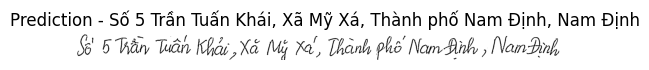

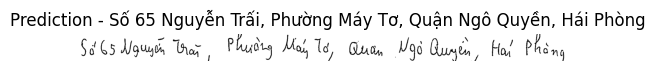

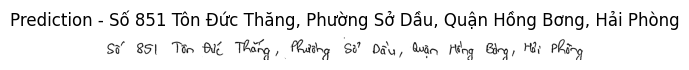

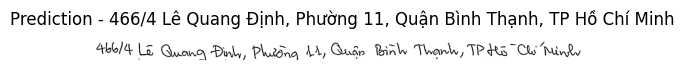

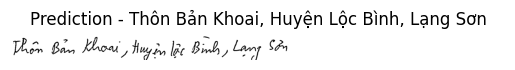

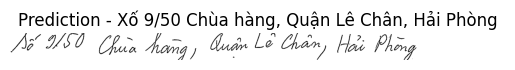

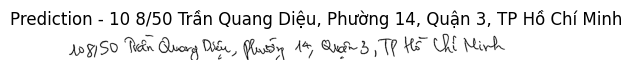

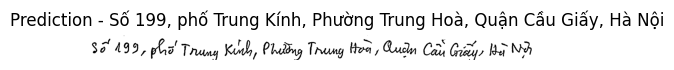

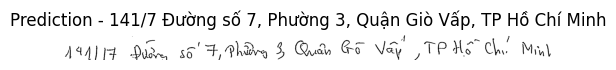

In [ ]:
act_model.load_weights("/content/drive/MyDrive/XLA/chkpt/40_13.3810.weights.h5")

test_image_paths = "/content/drive/MyDrive/XLA/Dataset/image_test"

test_images = [process_image(os.path.join(test_image_paths, img_path)) for img_path in os.listdir(test_image_paths)]
test_images = np.array(test_images)

predictions = []
pred = act_model.predict(test_images)
out = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
for x in out:
    pred = ""
    for p in x:
        if int(p) != -1:
            pred += char_list[int(p)]
    predictions.append(pred)


from matplotlib import pyplot as plt
for i in range(len(predictions)):
    plt.title("Prediction - {}".format(predictions[i]))
    plt.imshow(test_images[i][:,:,0], cmap="gray_r")
    plt.axis('off')
    plt.show()